In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm
import os

In [15]:
# Between two nlm states
transition_dipole_moment = stark_int(n_1=50, n_2=51, l_1=0, l_2=1, m_1=0, m_2=0)
transition_dipole_moment

491.5268274202669

In [16]:
# In an electric field (with B=0)
# quantum numbers
nmin = 5
nmax = 9
S = 1
n_vals, L_vals, m_vals = get_nlm_vals(nmin, nmax)
J_vals = get_J_vals(S, L_vals, 1)
# quantum defects
neff = n_vals - get_qd(S, n_vals, L_vals, J_vals)
# energy levels
En = W_n(S, n_vals, L_vals, J_vals)
# field orientation
field_orientation = 'parallel'
# field-free Hamiltonian
H_0 = np.diag(En)
# find the off-diagonal terms of the Stark interaction matrix
mat_S = stark_matrix(neff, L_vals, m_vals, field_orientation)

calculate Stark terms: 100%|█████████████████| 255/255 [00:02<00:00, 90.55it/s]


In [17]:
# specify the electric field
field = np.linspace(0.00, 100000.0, 201) # V /cm
field_au = field * 100 * e * a_0 / En_h
# specify the magnetic field (in Telsa)
#B_z = 1.5776E-3
# (in atomic units)
#B_z_au = B_z / (2.35*10**5)
# Zeeman interaction Hamiltonian
#H_Z = np.diag(E_zeeman(m_vals, B_z_au))
# diagonalise for each field
eig_vals, eig_vecs = stark_map_vec(H_0, mat_S, field_au)

diagonalise Hamiltonian: 100%|██████████████| 201/201 [00:01<00:00, 154.07it/s]


## Transition dipole moment between two states

State 1: 		 n= 7 , l= 0 , m= 0
State 2: 		 n= 8 , l= 1 , m= 0


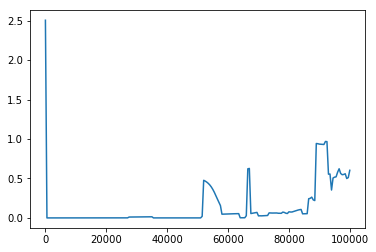

In [39]:
state_1 = 5**2 + 6**2 + 0
state_2 = 5**2 + 6**2 + 7**2 + 2
print('State 1: \t\t n=', n_vals[state_1], ', l=', L_vals[state_1], ', m=', m_vals[state_1])
print('State 2: \t\t n=', n_vals[state_2], ', l=', L_vals[state_2], ', m=', m_vals[state_2])

transition_dipole_moment = []
for i, f in enumerate(field):
    weightings = np.outer( eig_vecs[i,state_1], eig_vecs[i,state_2] )
    transition_dipole_moment.append( np.sum( np.abs(mat_S * weightings) ) )

plt.plot(field, transition_dipole_moment)

## State character of a state

State: 		 n= 7 , l= 0 , m= 0
Character: 	 n= 7 , l= 1 , m= 1


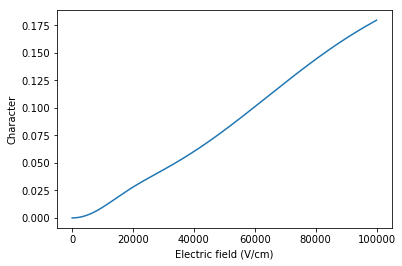

In [19]:
state = 5**2 + 6**2 + 0
character = 5**2 + 6**2 + 3
print('State: \t\t n=', n_vals[state], ', l=', L_vals[state], ', m=', m_vals[state])
print('Character: \t n=', n_vals[character], ', l=', L_vals[character], ', m=', m_vals[character])

plt.plot(field, np.abs(eig_vecs[:,state,character]**2))
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Character')

## Stark map

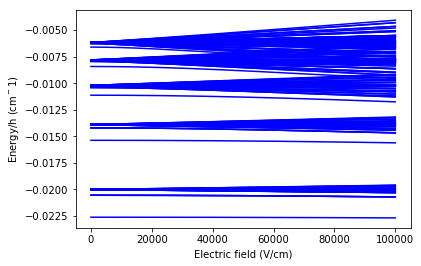

In [20]:
for i in np.arange(0, len(eig_vals[0]), 1): 
    plt.plot(field, eig_vals[:,i], '-b')
    
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/h (cm$^-1$)')

## L character of a state

State: 		 n= 7 , l= 2 , m= 0
Character: 		 l= 2


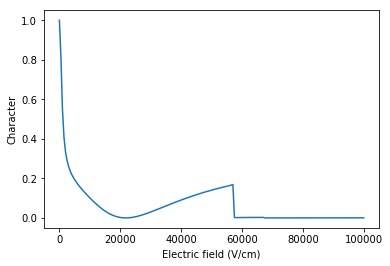

In [21]:
state = 5**2 + 6**2 + 6 
L_char = 2
print('State: \t\t n=', n_vals[state], ', l=', L_vals[state], ', m=', m_vals[state])
print('Character: \t\t l=', L_char )

eig_vec_with_char = eig_vecs[:, state, np.where(L_vals==L_char)]
plt.plot(field, np.sum( eig_vec_with_char**2, axis=2 ) )
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Character')

## L character of states

State from: 		 n= 6 , l= 5 , m= 0
State to: 		 n= 7 , l= 2 , m= 0
Character: 		 l= 2


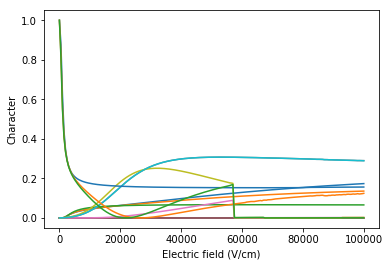

In [26]:
state_from = 5**2 + 6**2 - 6
state_to = 5**2 + 6**2 + 6
L_char = 2
print('State from: \t\t n=', n_vals[state_from], ', l=', L_vals[state_from], ', m=', m_vals[state_from])
print('State to: \t\t n=', n_vals[state_to], ', l=', L_vals[state_to], ', m=', m_vals[state_to])
print('Character: \t\t l=', L_char )

for state in np.arange(state_from, state_to+1, 1):
    eig_vec_with_char = eig_vecs[:, state, np.where(L_vals==L_char)]
    plt.plot(field, np.sum( eig_vec_with_char**2, axis=2 ) )

plt.xlabel('Electric field (V/cm)')
plt.ylabel('Character')